In [56]:
%pip install polars matplotlib numpy pandas seaborn scikit-learn pyarrow biopython
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
from Bio import Phylo
import os
from matplotlib import gridspec

sns.set_theme(context="paper")


Note: you may need to restart the kernel to use updated packages.


In [57]:
gc = (
    pl.read_csv(
        "../results/windows/gc.bed",
        has_header = False,
        separator = "\t",
        comment_prefix="#",
    )
    .with_columns(
        [
            (pl.lit("gc").alias("feature")),
            (pl.col("column_1").alias("chrom")),
            (pl.col("column_2").alias("start")),
            (pl.col("column_3").alias("end")),
            (pl.col("column_5").alias("proportion")),
        ]
    )
    .select(["feature", "chrom", "start", "end", "proportion"])
)

genes = (
    pl.read_csv(
        "../results/windows/genes.bed",
        has_header = False,
        separator = "\t",
        comment_prefix="#",
    )
    .with_columns(
        [
            (pl.lit("genes").alias("feature")),
            (pl.col("column_1").alias("chrom")),
            (pl.col("column_2").alias("start")),
            (pl.col("column_3").alias("end")),
            (pl.col("column_7").alias("proportion")),
        ]
    )
    .select(["feature", "chrom", "start", "end", "proportion"])
)

ty1 = (
    pl.read_csv(
        "../results/windows/Ty1.bed",
        has_header = False,
        separator = "\t",
        comment_prefix="#",
    )
    .with_columns(
        [
            (pl.lit("ty1").alias("feature")),
            (pl.col("column_1").alias("chrom")),
            (pl.col("column_2").alias("start")),
            (pl.col("column_3").alias("end")),
            (pl.col("column_7").alias("proportion")),
        ]
    )
    .select(["feature", "chrom", "start", "end", "proportion"])
)

ty3 = (
    pl.read_csv(
        "../results/windows/Ty3.bed",
        has_header = False,
        separator = "\t",
        comment_prefix="#",
    )
    .with_columns(
        [
            (pl.lit("ty3").alias("feature")),
            (pl.col("column_1").alias("chrom")),
            (pl.col("column_2").alias("start")),
            (pl.col("column_3").alias("end")),
            (pl.col("column_7").alias("proportion")),
        ]
    )
    .select(["feature", "chrom", "start", "end", "proportion"])
)

methylation = (
    pl.read_csv(
        "../results/windows/methylation.tab",
        has_header=False,
        separator="\t",
        comment_prefix="#",
    )
    .rename(
        {
            "column_1": "chrom",
            "column_2": "start",
            "column_3": "end",
            "column_4": "CG",
            "column_5": "CHG",
            "column_6": "CHH",
        }
    )
    .melt(id_vars=["chrom", "start", "end"], variable_name="feature", value_name="proportion")
)

features_df = pl.concat([gc, genes, ty1, ty3, methylation], how = "align")


In [51]:
features_df = features_df.filter(pl.col("chrom").str.contains("chr"))

plot = sns.FacetGrid(
    features_df,
    col="chrom",
    row="feature",
    sharex=False,
    sharey="row",
    margin_titles=True,
)

plot.map(
    sns.barplot,
    "start",
    "proportion",
    "proportion",
    width = 1
)

NameError: name 'features_df' is not defined

Get some summary statistics and plots for the RNAseq dataset

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_58014/2696872484.py:35: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()


<Figure size 3540x1800 with 0 Axes>

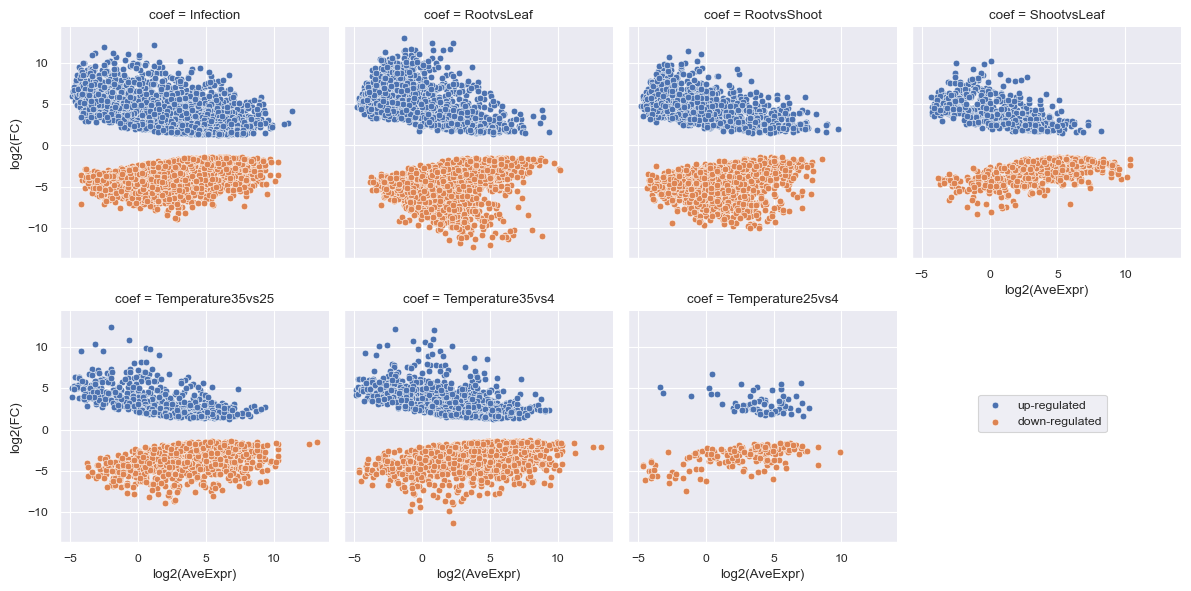

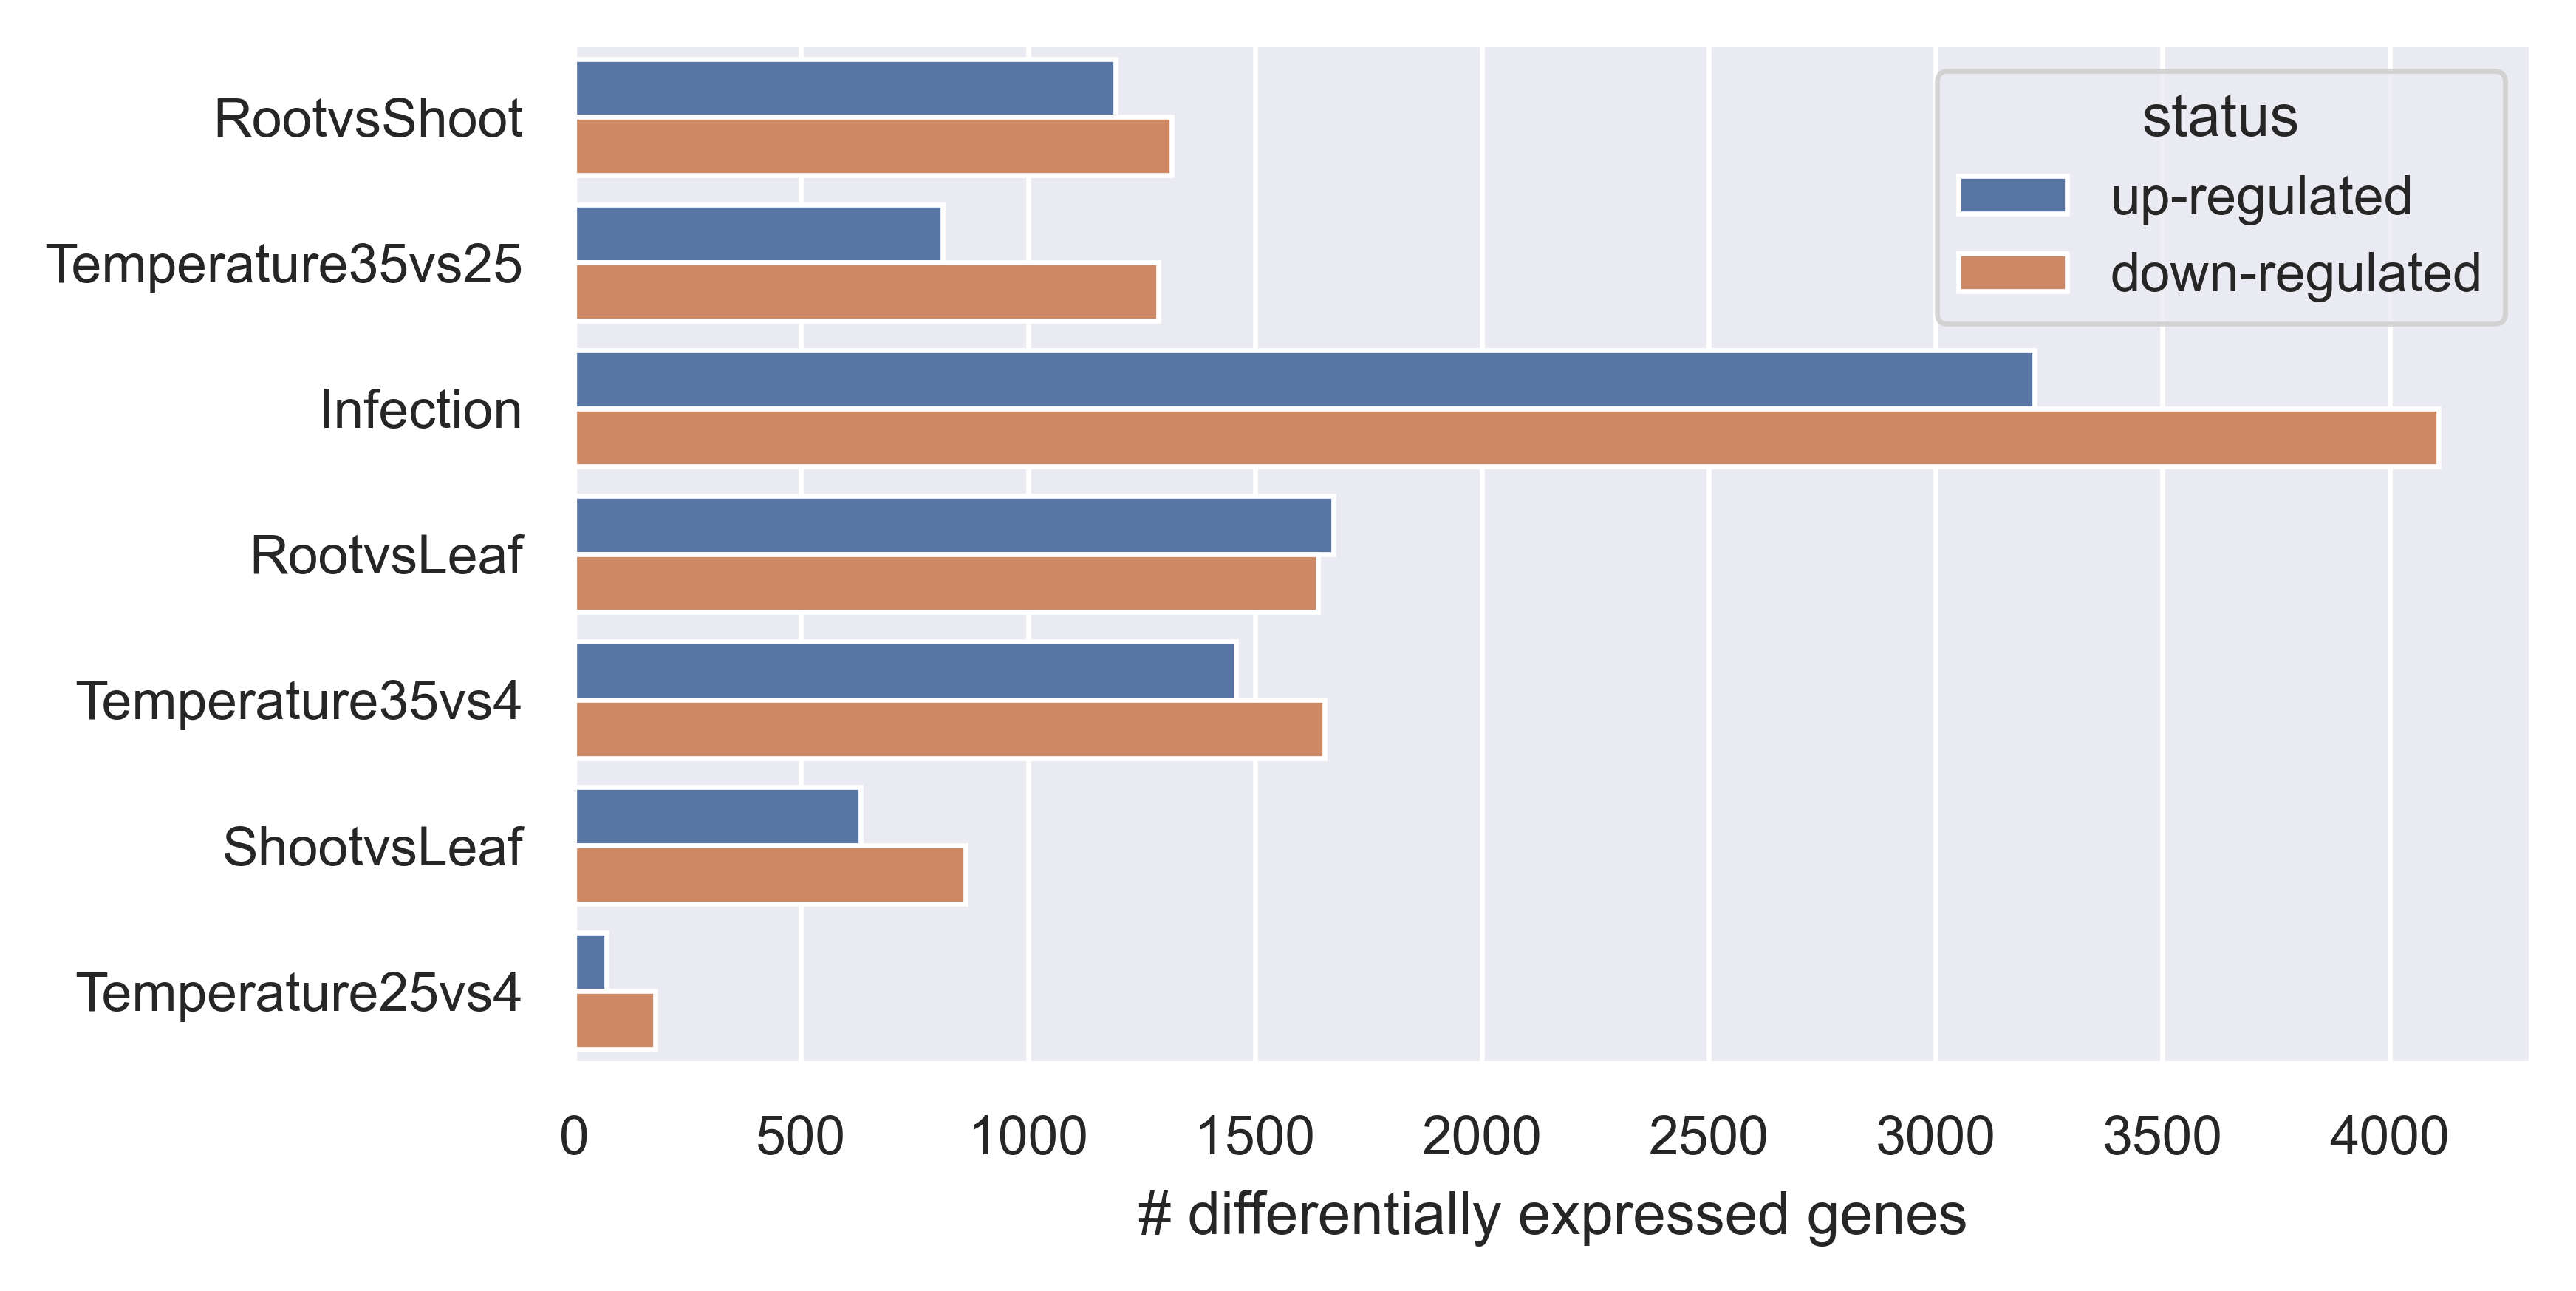

In [80]:
de_genes = pl.read_csv(
    "../results/differential_expression.tsv",
    separator="\t",
    has_header=True,
)

lcpm = pl.read_csv(
    "../results/lcpm.tsv",
    separator="\t",
    has_header=True,
)

plt.figure(figsize=(5.9, 3), dpi=600)
ma_plot = sns.FacetGrid(
    de_genes.filter(pl.col("status") != "not significant"),
    col="coef",
    col_wrap=4,
    hue="status",
)
ma_plot = ma_plot.map(
    sns.scatterplot,
    "AveExpr",
    "logFC",
)
ma_plot.set(xlabel="log2(AveExpr)", ylabel="log2(FC)")
plt.legend(loc="lower right", bbox_to_anchor=(1.8, 0.45))
plt.savefig("../../pandoc-thesis/figures/rnaseq_ma.png")

plt.figure(figsize=(5.9, 3), dpi=600)
de_barplot = sns.barplot(
    (
        de_genes
        .filter(pl.col("status") != "not significant")
        .group_by("coef", "status")
        .count()
    ),
    y="coef",
    x="count",
    hue="status",
)
de_barplot.set(xlabel="# differentially expressed genes", ylabel=None)
plt.tight_layout()
plt.savefig("../../pandoc-thesis/figures/rnaseq_de.png")

Make a clustered heatmap of the differentially expressed genes based on lcpm values

/opt/homebrew/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


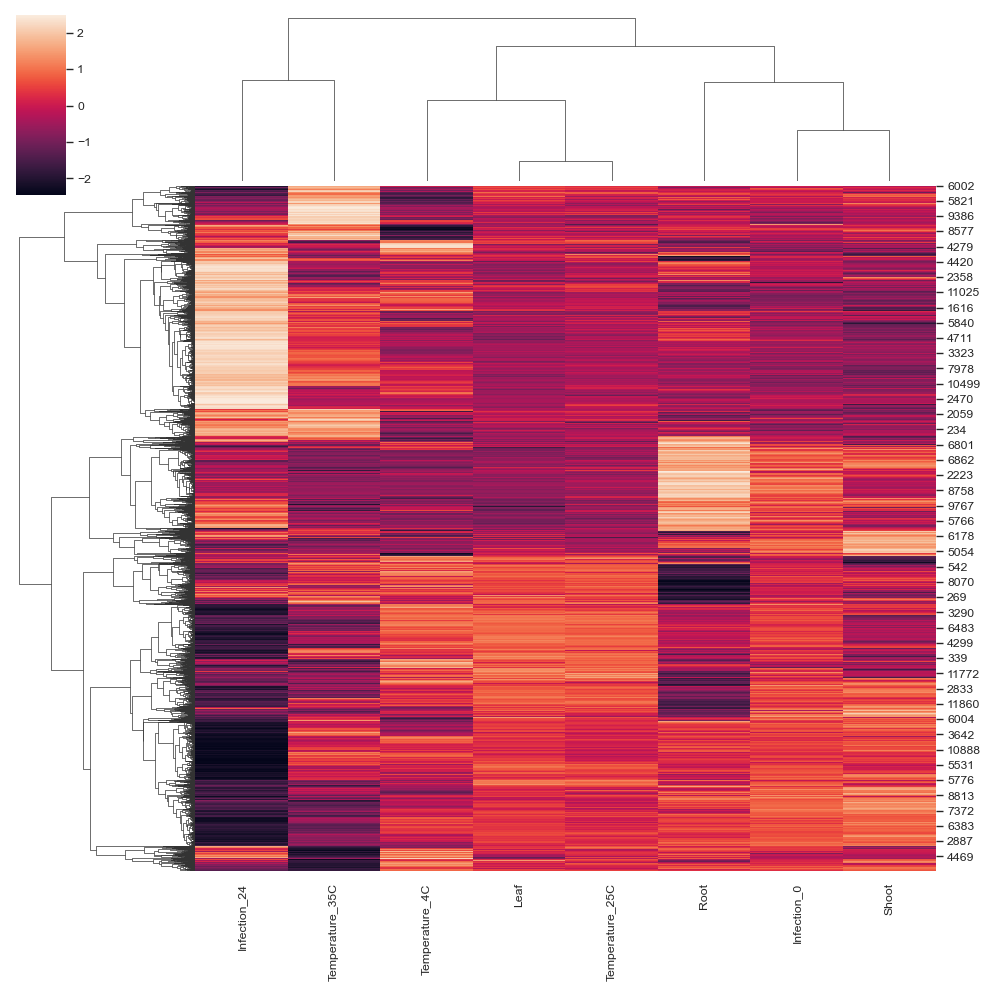

In [54]:
de_gene_list = (
    de_genes
    .filter(pl.col("status") != "not significant")
    .select("gene")
)

sns.clustermap(
    (
        lcpm
        .pivot(
            columns="condition",
            values="lcpm",
            index="gene"
        )
        .filter(pl.col("gene").is_in(de_gene_list))
        .drop("gene")
        .to_pandas()
    ),
    z_score=0,
    metric="correlation"
)